<div id="teaser" style=' background-position:  right center; background-size: 00px; background-repeat: no-repeat; 
    padding-top: 20px;
    padding-right: 10px;
    padding-bottom: 170px;
    padding-left: 10px;
    border-bottom: 14px double #333;
    border-top: 14px double #333;' > 

   
   <div style="text-align:center">
    <b><font size="6.4">Total cumulative mutual information</font></b>    
  </div>
    
<p>
 created by:
 Benjamin Regler<sup>1</sup>, 
 Matthias Scheffler<sup>1</sup>,
 and Luca Ghiringhelli<sup> 1</sup> <br><br>
<sup>1</sup> Fritz Haber Institute of the Max Planck Society, Faradayweg 4-6, D-14195 Berlin, Germany <br>
<span class="nomad--last-updated" data-version="v1.0.1">[Last updated: January 17, 2020]</span>
</p>
  
<div> 
    <img style="float: left;" src="assets/logo-mpg.png" width="200"> 
    <img style="float: right;" src="assets/logo-nomad.png" width="250">
</div>
</p>
</div>

Welcome to the supplementary material for the publication:

<div style="padding: 1ex; margin-top: 1ex; margin-bottom: 1ex; border-style: dotted; border-width: 1pt; border-color: blue; border-radius: 3px;">
B. Regler, M. Scheffler, and L. M. Ghiringhelli: "TCMI: a non-parametric mutual-dependence estimator for multivariate continuous distributions"
</div>

This interactive notebook includes the original implementation of total cumulative mutual information (TCMI) to reproduce the main results presented in the publication.

TCMI is a measure of the relevance of mutual dependencies based on cumulative probability distributions. TCMI can be estimated directly from sample data and is a non-parametric, robust and deterministic measure that facilitates comparisons and rankings between feature sets with different cardinality. The ranking induced by TCMI allows for feature selection, i.e. the identification of the set of relevant features that are statistical related to the process or the property of a system, while taking into account the number of data samples as well as the cardinality of the feature subsets.

It is compared to [Cumulative mutual information (CMI)](https://dx.doi.org/10.1137/1.9781611972832.22), [Multivariate maximal correlation analysis (MAC)](http://proceedings.mlr.press/v32/nguyenc14.html), [Universal dependency analysis (UDS)](https://dx.doi.org/10.1137/1.9781611974348.89), and [Monte Carlo dependency estimation (MCDE)](https://dx.doi.org/10.1145/3335783.3335795).

This repository (notebook and code) is released under the [Apache License, Version 2.0](http://www.apache.org/licenses/). Please see the [LICENSE](LICENSE) file.

---

**Important notes:**
<ul style="color: #8b0000; font-style: italic;">
<li>All comparisons have been computed with the Java package <code>MCDE</code> written in Scala, which is not part of the repository. To use the most recent and maintained implementation, please visit <a href="https://github.com/edouardfouche/MCDE">https://github.com/edouardfouche/MCDE</a> and run all examples with 50,000 iterations.</li>
<li>For the sake of simplicity, all results have been cached. However, results can be recalculated after adjusting the respective test sections. Depending on the test, the calculation time ranges from minutes to days.</li>
</ul>

---

In [1]:
# Toggle caching
use_cache = True

## Import modules

In [2]:
import os
import re
import shutil
import joblib
import warnings
import functools
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Our package
import tcmi
from tcmi import utils
from tcmi import entropy
from tcmi.cache import Cache
from tcmi.subspace_search import get_subspaces
from tcmi.estimators import DependenceEstimator


def get_storage_data(key, default=None, overwrite=False):
    """Wrapper for storage access. Uses use_cache.
    """
    return storage.get(key, default) if use_cache or overwrite else default


# Main loop
if __name__ == '__main__': 
    # Provide cache
    storage = Cache('data')
    
    # Configure plot environment
    mpl.rc('font', family='sans', size=14)
    mpl.rcParams.update({
        'figure.facecolor': (0, 0, 0, 0),
        'axes.facecolor': (0, 0, 0, 0),
        'xtick.labelsize': 14,
        'ytick.labelsize': 14
    })
    
    # Define colors
    cmap1 = plt.get_cmap('cividis')
    cmap2 = plt.get_cmap('RdBu_r')
    cmap_neutral = plt.get_cmap('binary')
    
    neutral_color1 = '#666666'
    neutral_color2 = '#999999'
    neutral_color3 = '#cccccc'
    
    # General settings (please do not touch)
    kwargs = dict(n_jobs=-1, return_scores=True)
    seed = 2019

## 1. Basic tests

This section studies some of the properties of total cumulative mutual information. In particular, we check that the

- score is a monotonous function in the order of the conditionals
- score attains it's maximum and minimun theoretical values (linear and zero case)
- correction vanishes with increasing number of data samples
- adjusted version of the score is (almost) constant with respect to subset dimensionality and sample size

In [5]:
# Test case 1
methods = ['cmi', 'mac', 'uds', 'mcde']
size = 200

# Test case 2
sizes = [10, 50, 100, 500]
n_repeats = 50
dimensions = 4

### 1.1. Monotonicity check and ranking of monotonous functions

**Test**: Monotonicity check of score<br />
**Expected**: linear must be first, followed by step functions, zero must be last

In [6]:
rng = np.random.RandomState(seed=seed)
tests = {
    # Common operations
    'linear': np.arange(size),
    'exponential': np.exp(np.linspace(0, 1, num=size)),

    # Adding copies of values
    'step_2': np.repeat(np.arange(size // 2), 2),
    'step_4': np.repeat(np.arange(size // 4), 4),
    'step_8': np.repeat(np.arange(size // 8), 8),

    # Interleave copies
    'sawtooth_2': np.stack(tuple(zip(*[np.arange(2) for i in range(size // 2)])),
                     axis=1).flatten(),
    'sawtooth_4': np.stack(tuple(zip(*[np.arange(4) for i in range(size // 4)])),
                     axis=1).flatten(),
    'sawtooth_8': np.stack(tuple(zip(*[np.arange(8) for i in range(size // 8)])),
                     axis=1).flatten(),
    
    'random': rng.random_sample(size),
    'zero': np.zeros(size)
}

ranks = {}
output = np.arange(size) + 1

for name, value in tests.items():
    # Compute scores from other dependency measures for comparison
    key = 'monotonicity-check-' + name   
    scores = get_storage_data(key, [], overwrite=True)
    
    if not scores:
        score, scores = entropy.cumulative_mutual_information(output, (value, ), **kwargs)
        scores = list(s.mean() for s in scores)
        
        # Compute scores from other dependency measures for comparison
        for method in methods:
            estimator = DependenceEstimator(method=method, n_jobs=-1)
            score = estimator.score(value, output)
            scores.append(score)
    
    ranks[name] = [np.around(s, decimals=4) for s in scores]
    
    # Compute correlation
    correlation = 0
    if np.unique(value).size > 1:
        correlation = sp.stats.spearmanr(output, value)[0]
    ranks[name].insert(0, np.around(correlation**2, decimals=4))

# Show ranking
ranks = sorted(ranks.items(), key=lambda x: x[1], reverse=True)
index, data = tuple(zip(*ranks))
data = np.array([(rho, total, s, np.sum([s01, s02])) + tuple(rest)
                 for rho, total, s, s01, s02, *rest in data])

columns = ['rho2', 'adjusted_score', 'score', 'score0']
columns.extend(methods)

ranks = pd.DataFrame(data, index=index, columns=columns)
ranks

,rho2,adjusted_score,score,score0,cmi,mac,uds,mcde
linear,1.0000,0.9743,1.0000,0.0257,1.0000,1.0000,0.6653,0.9979
exponential,1.0000,0.9743,1.0000,0.0257,0.4959,1.0000,0.6547,0.9977
step_2,0.9999,0.9588,0.9812,0.0224,1.0000,1.0000,0.6655,0.9978
step_4,0.9996,0.9269,0.9456,0.0187,1.0000,1.0000,0.6657,0.9977
step_8,0.9984,0.8673,0.8822,0.0149,1.0000,1.0000,0.6655,0.9976
random,0.0091,0.3285,0.6466,0.3181,0.0165,0.3376,0.0000,0.5354
sawtooth_8,0.0016,0.2326,0.3061,0.0735,0.0264,0.0273,0.0000,0.1391
sawtooth_4,0.0004,0.1744,0.2701,0.0957,0.0038,0.0144,0.0000,0.0876
sawtooth_2,0.0001,0.0903,0.1875,0.0972,0.0000,0.0000,0.0000,0.0347
zero,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9989


### 1.2. Dependence of the correction term

**Test**: Baseline correction dependence with respect to number of data samples<br />
**Expected**: Baseline correction monotonically decreases in the number of data samples

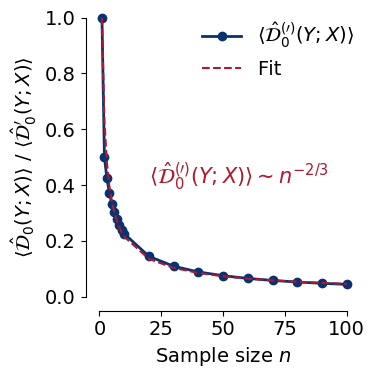

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0
0,1.0,0.5,0.424673,0.372276,0.333224,0.302749,0.278171,0.257845,0.240703,0.226015,0.144956,0.10951,0.089073,0.075596,0.065964,0.058698,0.053,0.048399,0.044597


In [7]:
key = 'correction-term'
steps = np.concatenate((np.linspace(1, 9, num=9), np.linspace(10, 100, num=10)))

values = get_storage_data(key, [])
if len(values) == 0:
    values = np.zeros(len(steps), dtype=np.float_)
    for i, size in enumerate(steps):
        output = np.arange(size) + 1
        if size == 1:
            values[i] = 1
            continue

        ce = entropy.cumulative_entropy(output)
        hce0 = entropy.cumulative_baseline_correction(output, output, n_jobs=-1)
        score0 = 1 - hce0 / ce

        # Save average score
        values[i] = score0.mean()
    
##
# Plot dependence
##    
offset = 19
fig, ax = plt.subplots(figsize=plt.figaspect(1), dpi=100)

# Plot baseline correction
ax.plot(steps[:offset], values[:offset], '-o', color=cmap1(0.1),
        clip_on=False, linewidth=2, label=r'$\langle \hat{\mathcal{D}}^{(\prime)}_0(Y; X) \rangle$')
ax.plot(steps[:offset], steps[:offset]**(-2/3), color=cmap2(0.9),
        linestyle='--', label='Fit')

# Show approximate relationship
ax.annotate(r'$\langle \hat{\mathcal{D}}^{(\prime)}_0(Y; X) \rangle \sim n^{-2/3}$',
            (20, 0.4), color=cmap2(0.9),fontsize=15)

# Plot styles
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

# Set axis limits
ax.set_xlim(0, steps[offset - 1])
ax.set_ylim(0, 1)

ax.set_xlabel('Sample size $n$')
ax.set_ylabel(r'$\langle \hat{\mathcal{D}}_0(Y; X) \rangle\ /\ \langle \hat{\mathcal{D}}_0^\prime(Y; X) \rangle$')

ax.legend(loc='upper right', facecolor='w', frameon=False, bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.show()

# Show table
pd.DataFrame(np.atleast_2d(values), columns=steps)

### 1.3. Baseline correction

**Test**: Baseline correction of measure with respect to number of samples and dimension<br />
**Expected**: Constant scores for different dimensionalities and number of samples

In [8]:
dtypes = [('dimension', np.int), ('total_score', np.float_),
          ('score', np.float_), ('score_corr', np.float_), ('score0', np.float_)]
    
results = {}
for size in sizes:
    output = np.arange(size) + 1
    print('\nSize: {:d}'.format(size))
    
    dtypes = [('dimension', np.int), ('total_score', np.float_),
              ('score', np.float_), ('score_corr', np.float_), ('score0', np.float_)]
    
    scores_mean = np.zeros(dimensions + 1, dtype=dtypes)
    scores_std = np.zeros(dimensions + 1, dtype=dtypes)
    for i, dimension in enumerate(range(dimensions + 1)):
        print('- Dimension: {:d} '.format(dimension), end='   ')
        key = 'baseline_correction_size={:d}_dimension={:d}_repeats={:d}'.format(size, dimension, n_repeats)
        
        scores = get_storage_data(key, None)
        if scores is None:            
            # Make sure results are reproducible
            rng = np.random.RandomState(seed=seed)
            scores = []
            
            for _ in range(n_repeats):
                if dimension < 1:
                    # Add predictions on special first dimensional case
                    z = [rng.random_sample(size)]
                    
                    noise = 2 * rng.random_sample(size) - 1
                    z.append(z[0] + 0.1 * noise)
                else:
                    z = [rng.random_sample(size) for _ in range(dimension)]
            
                _, score = entropy.cumulative_mutual_information(output, z, **kwargs)
                scores.append(score)
            
                # Show update
                print('.', end='')
            
        # Collect statistics
        scores_mean[i] = (dimension, ) + tuple(np.mean(score) for score in zip(*scores))
        scores_std[i] = (dimension, ) + tuple(np.std(score) for score in zip(*scores))
        print('')
    results[size] = (scores_mean, scores_std)


Size: 10
- Dimension: 0    
- Dimension: 1    
- Dimension: 2    
- Dimension: 3    
- Dimension: 4    

Size: 50
- Dimension: 0    
- Dimension: 1    
- Dimension: 2    
- Dimension: 3    
- Dimension: 4    

Size: 100
- Dimension: 0    
- Dimension: 1    
- Dimension: 2    
- Dimension: 3    
- Dimension: 4    

Size: 500
- Dimension: 0    
- Dimension: 1    
- Dimension: 2    
- Dimension: 3    
- Dimension: 4    


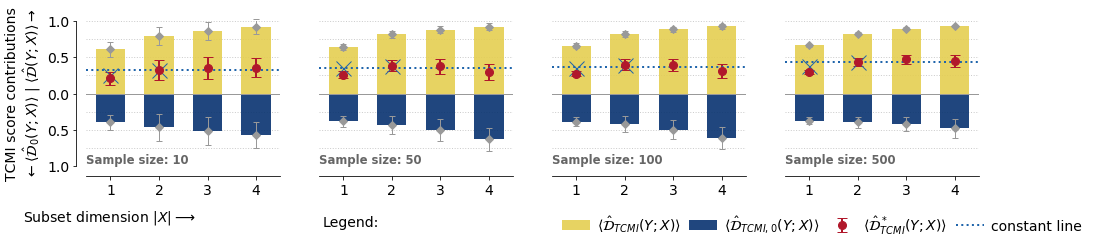

In [9]:
##
# Ploat data
##

fig, axs = plt.subplots(1, len(results), figsize=plt.figaspect(1/(len(results) + 0.1)))
axs = axs.flatten()

x = np.arange(1, dimensions + 1)
y = np.linspace(-1, 1, num=5)
margin = 0.5

for i, (ax, key) in enumerate(zip(axs, sorted(results))):    
    # Show reference lines
    for value in np.linspace(-1, 1, num=9):
        ax.axhline(value, color=neutral_color3, linewidth=1, linestyle=':', zorder=-1)
    ax.axhline(0, color=neutral_color2, linewidth=1)

    # Add up all corrections to the score
    scores_mean, scores_std = results[key]
    scores_zero = (scores_mean['total_score'][0], scores_std['total_score'][0])
    
    scores_mean = [(adjusted_score, score, np.sum(score0))
                   for dimension, adjusted_score, score, *score0 in scores_mean[1:]]
    adjusted_score, score, score0 = [np.array(values) for values in zip(*scores_mean)]
    
    scores_std = [(adjusted_score, score, np.sum(score0))
                  for dimension, adjusted_score, score, *score0 in scores_std[1:]]
    adjusted_score_std, score_std, score0_std = [np.array(values) for values in zip(*scores_std)]
    
    # Plot special point
    ax.errorbar([1, 2], [scores_zero[0], adjusted_score[1]],
                fmt='x', #yerr=[scores_zero[1], 0]
                color=cmap2(0.1), markersize=15, capsize=5, linewidth=5)

    # Show trend line
    constant = np.ones_like(adjusted_score)    
    model = np.column_stack((constant, constant))
    
    corrected_score = adjusted_score.copy()
    corrected_score[0] = scores_zero[0]

    coeff = np.linalg.lstsq(model, corrected_score, rcond=-1)[0]
    ax.axhline(np.sum(coeff), color=cmap2(0.1), linewidth=2, linestyle=':',
               label='constant line')

    # Plot score contributions
    ax.bar(x, score, color=cmap1(0.9), width=0.6,
           label=r'$\langle \hat{\mathcal{D}}_{TCMI}(Y; X) \rangle$', alpha=0.9)
    errors = ax.errorbar(x, score, yerr=score_std, color=neutral_color2, clip_on=False,
                         fmt='D', markersize=6, capsize=3, linewidth=1, linestyle=None)
    for b in errors[1]:
        b.set_clip_on(False)
    
    ax.bar(x, -score0, bottom=0, color=cmap1(0.1), width=0.6,
           label=r'$\langle \hat{\mathcal{D}}_{TCMI, 0}(Y; X) \rangle$', alpha=0.9)
    ax.errorbar(x, -score0, yerr=score0_std, color=neutral_color2, clip_on=False,
                fmt='D', markersize=6, capsize=3, linewidth=1, linestyle=None)
    
    ax.errorbar(x, adjusted_score, yerr=adjusted_score_std, color=cmap2(0.9),
                fmt='o', label=r'$\langle \hat{\mathcal{D}}_{TCMI}^*(Y; X) \rangle$', markersize=8,
                capsize=5, linewidth=2)

    ax.text(x[0] - margin, y[0], 'Sample size: {:d}'.format(key), ha='left',
            va='bottom', fontweight='bold', color=neutral_color1, fontsize='small')
    
    # Plot styles
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.set_xlim(x[0] - margin, x[-1] + margin)
    #ax.set_xlabel('Subset dimension $|X|$')
    
    # Show axis only for first subfigure
    if i > 0:
        ax.set_yticklabels([])
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
    else:
        ax.set_yticks(y)
        ax.set_yticklabels(['{:.1f}'.format(v) for v in np.abs(y)])
        ax.set_ylabel('TCMI score contributions\n'
                      r'$\leftarrow \langle \hat{\mathcal{D}}_0(Y; X) \rangle$ | '
                      r'$\langle \hat{\mathcal{D}}(Y; X) \rangle \rightarrow$')
    ax.set_ylim(y[0], y[-1])
    
    # Set equal aspect ratio for all figures
    ax.set_aspect(1.5)
    
    # Show legend
    if ax is axs[-1]:
        handles, labels = ax.get_legend_handles_labels()
        handles.append(handles.pop(0))
        labels.append(labels.pop(0))
        cax = fig.add_axes([0.91, 1, .5, 1])
        
        # HACK: Create legend in different context
        legend = plt.legend(handles, labels, loc='lower right', facecolor='w',
                            ncol=4, handletextpad=0.5, handlelength=2,
                            columnspacing=0.6, bbox_to_anchor=(0.18, -1.05), frameon=False)
        cax.remove()
        fig.add_artist(legend)
        
        ax.text(0.33, 0.03, 'Legend:', transform=fig.transFigure)
        ax.text(0.07, 0.05, r'Subset dimension $|X| \longrightarrow$', transform=fig.transFigure)

plt.show()

### 1.4. Invariance against scaling

**Test**: Invariance of TCMI against invertible transformations<br />
**Expected**: Same score (here: showcases some very simple examples)

In [10]:
short_size = 50
xx = 2 * np.random.random_sample(short_size) - 1
yy = np.linspace(0, 1, num=short_size)

target = 'y'
data = pd.DataFrame({'y': yy, 'x1': xx, 'x2': np.exp(xx), 'x3': xx**3 + xx})

estimator = DependenceEstimator(method='tcmi', n_jobs=-1)
get_subspaces(data, target, estimator, cv=None, verbose=1, depth=1,
              scoring='mutual_information_score', n_jobs=-1);

Subspace: {}  ->  [-inf +- 0.00]
x1                                                                                    [Score:  0.22 +-  0.00]
x2                                                                                    [Score:  0.22 +-  0.00]
x3                                                                                    [Score:  0.22 +-  0.00]
Bound: -inf -> -inf
[2020-01-17 10:14:14 - 0 subspaces remaining]


Balance search tree


## 2. Bivariate Gaussian distribution

In this section, we examine a simple feature selection task with a known distribution and nonlinear dependencies between features and the output variable. Essentially, we consider bivariate Gaussian distributions with different sample sizes, add noisy features, and test dependency estimators to find the optimal subset of features. Since the ground truth is known and the problem is two-dimensional, we expect only two traits to be selected by all dependency estimators.

**Settings:**

In [11]:
methods = ['tcmi', 'cmi', 'mac', 'uds', 'mcde']
sizes = [50, 100, 200, 500]

seed = 2019
num_splits = 10
num_repeats = 500

# Test case
noise_levels = 5
num_samples = 500
confidence = 0.95

**The dataset:**

In [12]:
target = 'Gaussian'
data = pd.read_csv('data/2d_gaussian.csv', low_memory=False)
#data = utils.prepare_data(data, target)

# Get data
x, z = data.drop(labels=target, axis=1), data[target]

# Setup noise levels
noises = np.linspace(0, 1, num=noise_levels + 1)

# Generate indices for sub-sampling
rng = np.random.RandomState(seed=seed)
indices = np.arange(data.shape[0])
rng.shuffle(indices)

# Plot empirical mean and covariance
xy = np.vstack((data['x'], data['y']))
pretty_print = lambda x: re.sub('\s+', ' ', repr(x))
print('Empirical mean       = {}\nEmpirical covariance = {}'
      .format(pretty_print(np.mean(xy, axis=-1)), pretty_print(np.cov(xy))))

Empirical mean       = array([-0.01529728, 0.0134394 ])
Empirical covariance = array([[0.98049267, 0.51549993], [0.51549993, 1.01985939]])


### 2.1. Check score of optimal feature subset

**Test**: List TCMI scores for optimal two-dimensional subset `{x,y}`<br />
**Expected**: TCMI scores of `{x,y}`

In [13]:
estimator = DependenceEstimator(method='tcmi', n_jobs=-1)
key = 'gaussian_optimal_subspace'

gaussian = data.iloc[indices[:sizes[-1]]]

scores = get_storage_data(key, None)
if scores is None:
    scores = []
    for k1, k2 in itertools.product(['x', '-x', '|x|', '-|x|'], ['y', '-y', '|y|', '-|y|']):
        temp_xy, temp_z = gaussian[[k1, k2]], gaussian[target]
        score = estimator.score(temp_xy, temp_z)
        scores.append((k1, k2, score))
        
    scores.sort(key=lambda x: -x[-1])

print('\n'.join('{{{:s},{:s}}} = {:.3f}'.format(*s) for s in scores))

{-|x|,-|y|} = 0.551
{|x|,y} = 0.527
{-x,|y|} = 0.522
{|x|,-y} = 0.521
{x,|y|} = 0.515
{x,-y} = 0.492
{x,y} = 0.489
{-x,y} = 0.472
{|x|,|y|} = 0.471
{-x,-y} = 0.465
{|x|,-|y|} = 0.411
{x,-|y|} = 0.406
{-|x|,|y|} = 0.392
{-x,-|y|} = 0.391
{-|x|,-y} = 0.373
{-|x|,y} = 0.370


### 2.2. Compute subset score

**Test**: Compute subset score `{x, y}` -> z with respect to increasing number of data points<br />
**Expected**: Monotonic increase for information-theoretic measures

In [14]:
results = {}
for size in sizes:
    gaussian = np.take(xy, indices[:size], axis=-1)
    output = np.take(z, indices[:size], axis=0)
    gaussian = gaussian.T
    
    results[size] = {}
    for method in methods:
        estimator = DependenceEstimator(method=method, n_jobs=-1)
        key = 'gaussian_xy_{:s}_{:d}'.format(method, size)
        
        score = get_storage_data(key, default=None, overwrite=bool(method != 'tcmi'))
        if score is None:
            score = estimator.score(gaussian, output)        
        results[size].setdefault(method, score)
    
df = np.array([[results[size][method] for method in methods] for size in sizes])
pd.DataFrame(df, index=sizes, columns=methods)

,tcmi,cmi,mac,uds,mcde
50,0.372399,0.371234,0.837915,0.0,0.701287
100,0.511599,0.263093,0.723145,0.0,0.797058
200,0.514346,0.261742,0.627305,0.0,0.856580
500,0.489740,0.223698,0.358752,0.0,0.910764


### 2.3. Find optimal subset of features

**Test**: Find optimal subset of features<br />
**Expected**: Optimal subset must be `{x, y}`, prefactors allowed, feature "normal" is similar to "x" or "y"

In [15]:
results = {}
for size in sizes:
    gaussian = data.iloc[indices[:size]]
    
    print('\n/**'
          '\n * Data points = {:d}'
          '\n */'.format(size))
    
    results[size] = {}
    for method in methods:
        estimator = DependenceEstimator(method=method, n_jobs=-1)
        key = 'gaussian_subspace_{:s}_{:d}'.format(method, size)
        
        subsets = get_storage_data(key, default=None, overwrite=bool(method != 'tcmi'))
        if subsets is None:
            subsets = tcmi.get_subspaces(gaussian, target, estimator, cv=None,
                                         depth=2, scoring='mutual_information_score',
                                         fit_params=None, verbose=1, n_jobs=-1)
            
        subsets = utils.filter_subsets(subsets, remove_duplicates=True)
        
        output = []
        cursor = 3
        cursor = -1
        threshold = 1
        
        has_xy = False
        for i, subset in enumerate(subsets):
            subspace = subset['subspace']
            score = subset['stats']['mutual_information_score_mean']
            depth = len(subspace)
            
            if i == 0 or cursor == -1 or cursor > depth:
                line = '[{:>3d}] {{{:s}}} = {:.2f}'.format(
                    len(subspace), ','.join(subspace), score)
                output.append(line)
                
                if i > 0 or cursor == -1:
                    threshold = 0.95 * score
                    cursor = depth
            
            elif score > threshold:
                line = '[{:>3d}] {{{:s}}} = {:.2f}'.format(
                    len(subspace), ','.join(subspace), score)
                output.append(line)
        
        results[size].setdefault(method, subsets)
        print('\nMethod: {:s}\n  {:s}'.format(method, '\n  '.join(output)))
    print('')


/**
 * Data points = 50
 */

Method: tcmi
  [  2] {logistic,x} = 0.54
  [  2] {rayleigh,weibull} = 0.53
  [  2] {x,y} = 0.52
  [  1] {x} = 0.38

Method: cmi
  [  1] {y} = 1.00
  [  1] {logistic} = 1.00
  [  1] {triangular} = 1.00
  [  1] {laplace} = 1.00

Method: mac
  [  2] {y,laplace} = 0.90
  [  2] {y,x} = 0.89
  [  2] {y,triangular} = 0.89
  [  2] {y,exponential} = 0.89
  [  2] {y,normal} = 0.89
  [  2] {y,rayleigh} = 0.89
  [  2] {y,uniform} = 0.89
  [  2] {y,weibull} = 0.89
  [  2] {y,logistic} = 0.89
  [  1] {y} = 0.88

Method: uds
  [  1] {laplace} = 0.52

Method: mcde
  [  1] {y} = 0.84


/**
 * Data points = 100
 */

Method: tcmi
  [  2] {y,rayleigh} = 0.57
  [  2] {y,laplace} = 0.55
  [  2] {y,uniform} = 0.55
  [  1] {y} = 0.46

Method: cmi
  [  1] {y} = 1.00
  [  1] {logistic} = 1.00
  [  1] {normal} = 1.00
  [  1] {triangular} = 1.00
  [  1] {laplace} = 1.00

Method: mac
  [  1] {x} = 0.84
  [  2] {x,laplace} = 0.82
  [  2] {x,logistic} = 0.82
  [  2] {x,weibull} = 0.82
 

### 2.4. Statistical power analysis (95% confidence)

To perform statistical power analysis we see, that all of the above dependency measures converge to the optimal feature subsets ${x,y}$ for at least 500 data samples, which will be chosen as the sample size in the following.

**Test**: Statistical power analysis (95% confidence)<br />
**Expected**: High statistical power as well as high contrast between the actual score and independence

In [16]:
def generate_dataset(data, target, noise, n_splits=10, n_repeats=100, seed=None):
    """Generate data set.
    """
    size = data.shape[0]

    # Convert cross-validation into number of data samples
    cv = np.floor(size * (n_splits if n_splits < 1 else (1 - 1 / n_splits))).astype(np.int_)

    # Initialize generator
    rng = np.random.RandomState(seed)
    indices = np.arange(size)

    # Evaluate dataset
    noise /= 2
    for _ in range(n_repeats):
        # Split dataset and make sure to make vectors immutable
        index = indices[:cv].copy()
        dataset = data.iloc[index].copy()
        
        # Add (centered) noise
        for key in dataset:
            if key == target:
                continue
            
            # Center noise around actual value
            dataset[key] += rng.uniform(-noise, noise, size=cv)

        # Return generated dataset
        yield dataset, index

        # Prepare for next iteration
        rng.shuffle(indices)
        
        
def compute_score(method, noise, dataset, indices):
    """Compute score for dataset.
    """
    # Setup
    test_xy, test_z = dataset.drop(labels=target, axis=1), dataset[target]
    estimator = DependenceEstimator(method=method, n_jobs=1, cache=None)
    h = cache.compute_hash((dataset, indices))

    # Compute measure with respect to output
    key = 'score_{:s}_{:.2f}_{:s}'.format(method, noise, h)
    score = storage.get(key, None)
    if score is None:
        score = estimator.score(test_xy, test_z)
        storage.set(key, score, retry=True)

    # Compute measure with respect to independent variables
    key = 'score0_{:s}_{:.2f}_{:s}'.format(method, noise, h)
    score0 = storage.get(key, None)
    if score0 is None:
        score0 = estimator.score(test_independent[indices], test_z)
        storage.set(key, score0, retry=True)

    # Return scores
    return score, score0


datasets = [
    ('Bivariate normal distribution: $\{x,y\}$', 'gaussian', 'data/2d_gaussian.csv', 
     'Gaussian', ('-|x|', '-|y|'))
]

collections = []
for label, name, file, target, subset in datasets:
    data = pd.read_csv(file, low_memory=False)
    if target == 'Delta E':
        del data['Combination']
        
    print('\n/**'
          '\n * Data set: {:s}'
          '\n */\n'.format(name))
        
    data = utils.prepare_data(data, target)
    size = min(len(data), num_samples)
    subset += (target, )

    # Setup noise levels
    noises = np.linspace(0, 1, num=noise_levels + 1)

    # Generate indices for test set
    rng = np.random.RandomState(seed=seed)
    indices = np.arange(len(data))
    rng.shuffle(indices)

    # Consider subset of data samples
    data = data[list(subset)].iloc[indices[:size]]
    test_independent = rng.uniform(0, 1, (size, 2))

    dtypes = [('noise', np.float_), ('power', np.float_),
              ('score', np.float_), ('score0', np.float_)]
    print('Data points = {:d}\nNoise levels = {:d}'
          .format(size, len(noises)))

    # Initialize joblib
    processor = joblib.Parallel(n_jobs=-1)
    callback = joblib.delayed(compute_score)
    
    # Compute statistical power
    collection = {}
    for method in methods:
        print('\nMethod: {:s}\n  '.format(method), end='')

        statistics = np.zeros(noises.size, dtype=dtypes)
        for i, noise in enumerate(noises):
            print('{:.2f}'.format(noise), end=', ')

            key = '{:s}_statistical_power_{:s}_{:d}_noise_{:.2f}'
            key = key.format(name, method, size, noise)
            values = get_storage_data(key, default=None, overwrite=bool(method != 'tcmi'))

            if values is None:
                # Perform calculation in parallel
                iterator = generate_dataset(data, target, noise, n_splits=num_splits,
                                            n_repeats=num_repeats, seed=seed)
                values = processor(callback(name, method, noise, dataset, indices)
                                   for dataset, indices in iterator)
                scores, scores0 = tuple(zip(*values))

                values = tuple(np.array(value) for value in zip(*values))

            # Compute statistical power
            scores, scores0 = values
            cutoff = np.quantile(scores0, confidence)

            power = np.mean(scores > cutoff)
            score_avg = scores.mean()
            score0_avg = scores0.mean()

            # Save statistical power statistics
            statistics[i] = (noise, power, score_avg, score0_avg)

        print('\n')
        for values in statistics:
            print('Noise = {:.2f}, Power = {:.2f}, Score = {:.2f}, Score0 = {:.2f}'.format(*values))     
        collection[method] = statistics
    
    collections.append((label, collection))


/**
 * Data set: gaussian
 */

Data points = 500
Noise levels = 6

Method: tcmi
  0.00, 0.20, 0.40, 0.60, 0.80, 1.00, 

Noise = 0.00, Power = 1.00, Score = 0.55, Score0 = 0.43
Noise = 0.20, Power = 0.89, Score = 0.50, Score0 = 0.43
Noise = 0.40, Power = 0.25, Score = 0.44, Score0 = 0.43
Noise = 0.60, Power = 0.02, Score = 0.39, Score0 = 0.43
Noise = 0.80, Power = 0.00, Score = 0.36, Score0 = 0.43
Noise = 1.00, Power = 0.00, Score = 0.34, Score0 = 0.43

Method: cmi
  0.00, 0.20, 0.40, 0.60, 0.80, 1.00, 

Noise = 0.00, Power = 1.00, Score = 0.21, Score0 = 0.01
Noise = 0.20, Power = 1.00, Score = 0.21, Score0 = 0.01
Noise = 0.40, Power = 1.00, Score = 0.21, Score0 = 0.01
Noise = 0.60, Power = 1.00, Score = 0.20, Score0 = 0.01
Noise = 0.80, Power = 1.00, Score = 0.20, Score0 = 0.01
Noise = 1.00, Power = 1.00, Score = 0.19, Score0 = 0.01

Method: mac
  0.00, 0.20, 0.40, 0.60, 0.80, 1.00, 

Noise = 0.00, Power = 1.00, Score = 0.55, Score0 = 0.52
Noise = 0.20, Power = 1.00, Score = 0.55, Sco

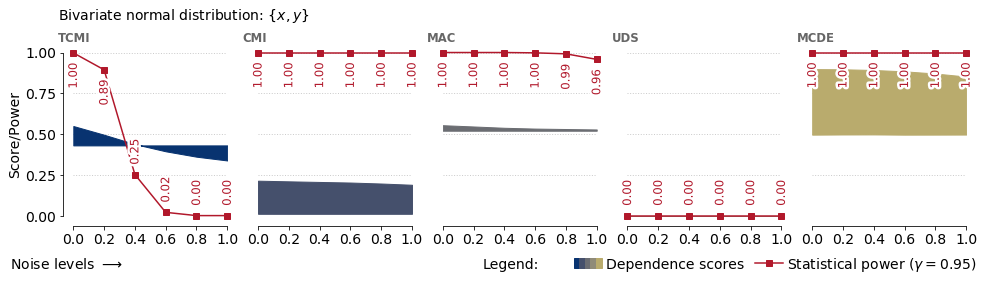

In [17]:
##
# Plot
##

from matplotlib.legend_handler import HandlerTuple
import matplotlib.patheffects as path_effects

# Plot
margin = 0.1
ncols = len(methods)
nrows = len(collections)
idx = np.where(np.arange(noise_levels + 1) % 2 == 0)[0]

fig, axs = plt.subplots(figsize=(16, 3 * nrows), ncols=ncols, nrows=nrows) 
if len(collections) == 1:
    axs = [axs]

handlers = []
for i, (caxs, item) in enumerate(zip(axs, collections)):
    name, collection = item
    
    for j, (ax, method) in enumerate(zip(caxs, methods)):
        # Show reference lines
        for y in np.linspace(0, 1, num=5):
            ax.axhline(y, color=neutral_color3, linewidth=1, linestyle=':', zorder=-1)

        # Get data
        data = collection[method]

        # Initialize coordinates
        x = data['noise']
        y = np.linspace(0, 1, num=5)
        color = 0.8 * (j / len(methods)) + 0.1

        # Show contrast of score
        score = np.maximum(data['score'] - data['score0'], 1e-2)
        bars = ax.bar(x, data['score'], data['score0'])
        handler = ax.fill_between(x, data['score'], data['score0'], color=cmap1(color),
                                  label='Dependence scores')
        handlers.append(handler)
        
        if j == 0:
            ax.text(x.min() - 0.1, y.max() + 0.17, name, va='bottom', ha='left')

        ax.plot(x, data['power'], color=cmap2(0.9), marker='s', clip_on=False,
                label='Statistical power ($\gamma = 0.95$)')

        ax.text(x[0] - margin, y[-1] + 0.05, method.upper(), ha='left',
                va='bottom', fontweight='bold', color=neutral_color1, fontsize='small')

        # Show statistical power
        for bar, value, value0, score0 in zip(bars, data['power'], score, data['score0']):
            bar_x = bar.get_x() + bar.get_width() / 2 # - 0.01 * bar.get_width()
            bar_y = bar.get_y() + bar.get_height() + 0.05
            text = '{:.2f}'.format(value)

            va = 'bottom'
            if value > 0.5:
                value -= 0.04
                va = 'top'

            if value < 0.5: # or value > 0.9:
                value += 0.08
                va = 'bottom'
                
            text = ax.text(bar_x, value - 0.02, text, ha='center', va=va,
                           fontsize='small', color=cmap2(0.9), rotation=90)
            text.set_path_effects(
                [path_effects.withStroke(linewidth=5, foreground='w')])

        bars.remove()

        # Plot styles
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.spines['left'].set_position(('outward', 10))
        ax.spines['bottom'].set_position(('outward', 10))

        ax.set_xticks(x)
        ax.set_xlim(x[0] - margin, x[-1] + margin)
        #ax.set_xlabel('Noise levels')

        # Show axis only for first subfigure
        if j > 0:
            ax.set_yticklabels([])
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
        else:
            ax.set_yticks(y)
            ax.set_yticklabels(['{:.2f}'.format(value) for value in y])
            ax.set_ylabel('Score/Power')
        ax.set_ylim(y[0], y[-1])
        ax.set_xlim(x[0], x[-1])
    
    # Show legend
    if caxs is axs[-1]:
        handles, labels = ax.get_legend_handles_labels() 
        handles[-1] = tuple(handlers)
        
        cax = fig.add_axes([1, 1, 0, 1])
        
        # HACK: Create legend in different context
        # https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/legend_demo.html
        legend = plt.legend(handles[::-1], labels[::-1], loc='upper right', facecolor='w',
                            ncol=3, handletextpad=0.3, handlelength=2, numpoints=1,
                            columnspacing=0.75, bbox_to_anchor=(0, -1), frameon=False,
                            handler_map={tuple: HandlerTuple(ndivide=None,pad=0)})
        
        # Get the bounding box of the original legend
        bb = legend.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

        # Change to location of the legend. 
        xOffset = -0.6
        bb.x0 += xOffset
        bb.x1 += xOffset
        legend.set_bbox_to_anchor(bb, transform = ax.transAxes)

        cax.remove()
        fig.add_artist(legend)
        
        ax.text(0.48, -0.12, 'Legend:', transform=fig.transFigure)
        ax.text(0.07, -0.12, r'Noise levels $\longrightarrow$', transform=fig.transFigure)

plt.show()

## 3. UCI Regression datasets

1. Friedman - https://sci2s.ugr.es/keel/dataset.php?cod=81 . It has been obtained from the LIACC repository. The original page where the data set can be found is: http://www.liaad.up.pt/~ltorgo/Regression/DataSets.html.
2. Concrete Compressive Strength - https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength
3. Forest Fires Data Set - https://archive.ics.uci.edu/ml/datasets/Forest+Fires

In [18]:
methods = ['tcmi', 'cmi', 'mac', 'uds', 'mcde']

### 3.1. Generate Friedman dataset

In [19]:
# https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/
# Friedman #1 regression dataset 

np.random.seed(0)
 
size = 500
target = 'y'

# "Friedamn #1” regression problem
X = np.random.uniform(0, 1, (size, 14))
Y = (10 * np.sin(np.pi*X[:,0]*X[:,1]) + 20*(X[:,2] - .5)**2 +
     10*X[:,3] + 5*X[:,4] + np.random.normal(0,1))
#Add 3 additional correlated variables (correlated with X1-X3)
X[:,10:] = X[:,:4] + np.random.normal(0, .025, (size,4))
 
names = ["x%s" % (i + 1) for i in range(X.shape[-1])]
data = pd.DataFrame(data=X, columns=names)
data[target] = Y

# data.to_csv('data/friedman.csv', index=False)

from scipy import stats

# Show which features have strong correlations
for key in data:
    if key == target:
        continue
    
    r2 = np.corrcoef(data[key], data[target])[0, 1]**2
    rho, pval = stats.spearmanr(data[key], data[target])
    print('{:<3s}: r2={:<4.2f}  rho={:>5.2f}  pval={:<.2g}'
          .format(key, r2, rho, pval))
    
x, z = data.drop(labels=target, axis=1), data[target]

x1 : r2=0.16  rho= 0.41  pval=2.8e-21
x2 : r2=0.18  rho= 0.44  pval=5.4e-25
x3 : r2=0.00  rho=-0.03  pval=0.44
x4 : r2=0.30  rho= 0.53  pval=4.3e-37
x5 : r2=0.06  rho= 0.22  pval=1e-06
x6 : r2=0.00  rho=-0.03  pval=0.44
x7 : r2=0.01  rho= 0.09  pval=0.057
x8 : r2=0.02  rho= 0.13  pval=0.0049
x9 : r2=0.01  rho= 0.09  pval=0.034
x10: r2=0.00  rho= 0.02  pval=0.59
x11: r2=0.16  rho= 0.41  pval=2.7e-21
x12: r2=0.18  rho= 0.44  pval=1.2e-24
x13: r2=0.00  rho=-0.04  pval=0.39
x14: r2=0.30  rho= 0.53  pval=1.5e-37


### 3.2. Optimal subspace search

**Test**: Find optimal subsets for several available datasets<br />
**Expected**: Convergence and stability of all dependence measures to the same subset

In [20]:
# Load datasets
datasets = [
    ('friedman', 'data/friedman.csv', 'y'),
    ('concrete', 'data/concrete.csv', 'compressive_strength'),
    ('forest_fires', 'data/forestfires.csv', 'area')
]

for name, filename, target in datasets:
    data = pd.read_csv(filename, low_memory=False)
    data = utils.prepare_data(data, target)
    
    print('\n/**'
          '\n * Model: {:s}'
          '\n */\n'
          '\nKeys: {{{:s}}}'
          '\nSize: {:d}'
          .format(name, ','.join(data), data.shape[-1] - 1))
    
    for method in methods:
        estimator = DependenceEstimator(method=method, n_jobs=1)
        key = 'subspace_search_{:s}_{:s}'.format(target, method)
        print('\nMethod: {:s}'.format(method))

        subsets = get_storage_data(key, default=None, overwrite=bool(method != 'tcmi'))
        if subsets is None:
            subsets = tcmi.get_subspaces(data, target, estimator, cv=None,
                                         depth=-1, scoring='mutual_information_score',
                                         fit_params=None, verbose=1, n_jobs=-1)

        output = []
        if len(subsets) > 1000:
            output.append('More than {:d} subsets.'.format(len(subsets)))
        else:            
            cursor = -1
            threshold = 1
            for i, subset in enumerate(subsets):
                subspace = subset['subspace']
                score = subset['stats']['mutual_information_score_mean']
                depth = len(subspace)

                if i == 0 or cursor == -1 or cursor > depth:
                    line = '[{:>3d}] {{{:s}}} = {:.2f}'.format(
                        len(subspace), ','.join(subspace), score)
                    output.append(line)

                    if i > 0 or cursor == -1:
                        threshold = 0.95 * score
                        cursor = depth

                elif score > threshold:
                    line = '[{:>3d}] {{{:s}}} = {:.2f}'.format(
                        len(subspace), ','.join(subspace), score)
                    output.append(line)
        print('  {:s}'.format('\n  '.join(output)))


/**
 * Model: friedman
 */

Keys: {x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,y,-x1,-x10,|x11|,-x11,-|x11|,|x12|,-x12,-|x12|,|x13|,-x13,-|x13|,|x14|,-x14,-|x14|,-x2,-x3,-x4,-x5,-x6,-x7,-x8,-x9}
Size: 36

Method: tcmi
  [  4] {|x14|,|x12|,x1,x5} = 0.77
  [  4] {|x14|,|x12|,x1,-x7} = 0.75
  [  4] {|x14|,|x12|,x1,x6} = 0.74
  [  4] {|x14|,|x12|,x1,-x9} = 0.74
  [  3] {|x14|,|x12|,x1} = 0.69
  [  3] {|x14|,|x12|,|x11|} = 0.68
  [  3] {|x14|,|x12|,x11} = 0.68
  [  3] {|x14|,|x12|,x5} = 0.66
  [  2] {|x14|,|x12|} = 0.53
  [  2] {|x14|,x12} = 0.53
  [  2] {|x14|,x2} = 0.52
  [  2] {|x14|,x5} = 0.52
  [  2] {|x14|,-x8} = 0.51
  [  1] {|x14|} = 0.35
  [  1] {x14} = 0.35
  [  1] {x4} = 0.34

Method: cmi
  [  1] {-x14} = 1.00
  [  1] {-x4} = 1.00
  [  1] {-|x14|} = 1.00
  [  1] {x14} = 1.00
  [  1] {x4} = 1.00
  [  1] {|x14|} = 1.00

Method: mac
  More than 119982 subsets.

Method: uds
  [  1] {-x1} = 0.00

Method: mcde
  [  1] {x2} = 0.78
  [  1] {-x2} = 0.77
  [  1] {x12} = 0.77
  [  1] {-

## 4. Octet-binary compound semiconductors

Octet-binary compound semiconductors are materials consisting of two elements formed by groups of I/VII, II/VI, III/V, or IV/IV elements leading to a full valence shell. They crystallize in rock salt (RS) or zinc blende (ZB) structures.

The data set is composed of 82 materials with two atomic species in the unit cell. The objective is to accurately predict the energy difference $\Delta E$ between RS and ZB structures based on 8 electro-chemical atomic properties for each atomic species $A/B$ (in total 16) such as atomic ionization potential $\text{IP}$, electron affinity $\text{EA}$, the energies of the highest-occupied and lowest-unoccupied Kohn-Sham levels, $\text{H}$ and $\text{L}$, and the expectation value of the radial probability densities of the valence $s$-, $p$-, and $d$-orbitals, $r_s$, $r_p$, and $r_d$, respectively.

<div style="padding: 1ex; margin-top: 1ex; margin-bottom: 1ex; border-style: dotted; border-width: 1pt; border-color: blue; border-radius: 3px;">
    L. M. Ghiringhelli, J. Vybiral, S. V. Levchenko, C. Draxl, C. & M. Scheffler: Big Data of Materials Science: Critical Role of the Descriptor. Physical Review Letters <strong>114</strong>, 105503 (2015). DOI: <a href="https://dx.doi.org/10.1103/PhysRevLett.114.105503">10.1103/PhysRevLett.114.105503</a>
</div>

The additional features from the reference are:

$$
\begin{equation}
    D1 = \frac{\text{IP}(B) - \text{EA}(B)}{r_p(A)^2}\ ,\quad \ D2 = \frac{|r_s(A) - r_p(B)|}{\exp[r_s(A)]}\ ,\quad D3 = \frac{|r_s(B) - r_p(B)|}{\exp[r_d(A)]} \ .
\end{equation}
$$

**Test**: Optimal feature subset search<br />
**Expected**: Find features to best predict $\Delta E$. Potential candidates are listed in the reference above

In [21]:
methods = ['tcmi', 'cmi', 'mac', 'uds', 'mcde']
data = pd.read_csv('data/octet-binary-compound-semiconductors.csv', low_memory=False)
materials = data.drop(columns='Combination', inplace=True)
target = 'Delta E'

# Add extra features from PRL
extra = {
    'D1': (data['EA(B)'] - data['IP(B)']) / data['rp(A)']**2,
    'D2': np.abs(data['rs(A)'] - data['rp(B)']) / np.exp(data['rs(A)']),
    'D3': np.abs(data['rp(B)'] - data['rs(B)']) / np.exp(data['rd(A)'])
}
# for k, v in extra.items():
#     data[k] = v

data = utils.prepare_data(data, target, copy=True)

print('\n/**'
      '\n * Model: Octet-binary compound semiconductor'
      '\n */\n'
      '\nKeys: {{{:s}}}'
      '\nSize: {:d}'
      .format(','.join(data), data.shape[-1] - 1))
        
method = 'tcmi'
estimator = DependenceEstimator(method=method)
    
key = 'binary_octets_{:s}'.format(method)
print('\nMethod: {:s}'.format(method))

subsets = get_storage_data(key, None)
if subsets is None: 
    subsets = tcmi.get_subspaces(data, target, estimator, cv=None,
                                 depth=-1, scoring='mutual_information_score',
                                 fit_params=None, verbose=1, n_jobs=-1)

threshold = 1
output = []
cursor = -1
subsets = utils.filter_subsets(subsets)

candidates = []
for i, subset in enumerate(subsets):
    subspace = subset['subspace']
    score = subset['stats']['mutual_information_score_mean']
    depth = len(subspace)

    if i == 0 or cursor == -1 or cursor > depth:
        line = '[{:>3d}] {{{:s}}} = {:.2f}'.format(
            len(subspace), ','.join(subspace), score)
        candidates.append((subspace, score))
        output.append(line)

        if i > 0 or cursor == -1:
            threshold = 0.95 * score
            cursor = depth

    elif score > threshold:
        line = '[{:>3d}] {{{:s}}} = {:.2f}'.format(
            len(subspace), ','.join(subspace), score)
        candidates.append((subspace, score))
        output.append(line)

print('  {:s}'.format('\n  '.join(output)))
keys = sorted([k for k in data.columns if k != target and '|' not in k and '-' not in k],
              key=lambda x: (x[-2], x))
candidates.insert(0, (keys, 1))


/**
 * Model: Octet-binary compound semiconductor
 */

Keys: {Delta E,EA(A),EN(A),H(A),IP(A),L(A),rd(A),rp(A),rs(A),EA(B),EN(B),H(B),IP(B),L(B),rd(B),rp(B),rs(B),|EA(A)|,-EA(A),-|EA(A)|,|EA(B)|,-EN(A),-EN(B),|H(A)|,|H(B)|,|IP(A)|,|IP(B)|,|L(A)|,-L(A),-|L(A)|,-L(B),-rd(A),-rd(B),-rp(A),-rp(B),-rs(A),-rs(B)}
Size: 36

Method: tcmi
  [  6] {rs(A),L(B),rp(A),EA(A),IP(B),rs(B)} = 0.82
  [  6] {rs(A),L(B),rp(A),EA(A),IP(B),rp(B)} = 0.82
  [  6] {rs(A),L(B),rp(A),EA(A),EN(B),rs(B)} = 0.82
  [  6] {rs(A),L(B),rp(A),EA(A),H(B),rs(B)} = 0.82
  [  6] {rp(A),L(B),EA(A),H(A),rd(A),rd(B)} = 0.82
  [  6] {rs(A),L(B),rp(A),EA(A),EN(B),rp(B)} = 0.82
  [  6] {rs(A),L(B),rp(A),EA(A),H(B),rp(B)} = 0.82
  [  6] {rs(A),L(B),EA(A),H(A),rd(A),rd(B)} = 0.82
  [  6] {rp(A),L(B),EA(A),H(A),rp(B),rd(B)} = 0.81
  [  6] {rp(A),L(B),EA(A),H(A),rs(B),rd(B)} = 0.81
  [  6] {rp(A),L(B),EA(A),H(A),rd(A),EA(B)} = 0.80
  [  6] {rs(A),L(B),EA(A),H(A),rd(A),IP(B)} = 0.80
  [  6] {rp(A),L(B),EA(A),H(A),rd(A),IP(B)} = 0.80
 